# # Training the model

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv1D, \
                                    UpSampling1D, Embedding, Multiply, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow_addons.layers import GELU, SpectralNormalization as SN

In [9]:
%matplotlib inline
file_name = 'cWGAN_GP_SN'
dir_name = file_name + '_dir'
ckpt_dir = dir_name + '/ckpt'
plots_dir = dir_name + '/plots'
os.mkdir(dir_name)
os.mkdir(ckpt_dir)
os.mkdir(plots_dir)

In [10]:
data = np.load('../../data/processed/full_data.npz')
electrical_data = data['electrical_data']
labels = data['labels']

## Define cWGAN-GP-SN Monitor Callback

In [12]:
class cWGAN_GP_SN_Monitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        if epoch % 20 == 0:
            print('\nSaving the generator at epoch', epoch)
            self.model.generator.save_weights(ckpt_dir + '/generator_weights_' + str(epoch) + '.ckpt')
            
            print('Saving the critic at epoch', epoch)
            self.model.critic.save_weights(ckpt_dir + '/critic_weights_' + str(epoch) + '.ckpt')
            
            print('Plotting generated samples')
            self.model.save_plots(epoch)

## Define cWGAN-GP-SN Class

In [13]:
class cWGAN_GP_SN(Model):
    def __init__(self, batch_size):
        super(cWGAN_GP_SN, self).__init__()
        
        # Constants and Shapes
        self.batch_size = batch_size
        self.gp_weight = 10
        self.nr_labels = 5
        self.max_labels = 28
        self.noise_length = 144
        self.seq_length = 8760
        self.nr_features = 6
        self.emb_length = 50
        self.gen_input_shape = (self.noise_length, self.nr_features)
        self.critic_input_shape = (self.seq_length, self.nr_features)
        
        # The Generator
        self.generator = self.build_generator()
        self.generator.summary()
        
        # The Critic
        self.c_steps = 5
        self.critic = self.build_critic()
        self.critic.summary()
        
    def compile(self):
        super(cWGAN_GP_SN, self).compile()
        self.c_optimizer = Adam(2e-4, 0.5, 0.9)
        self.g_optimizer = Adam(2e-4, 0.5, 0.9)
        self.c_loss_fn = self.critic_loss
        self.g_loss_fn = self.generator_loss
        
    def gradient_penalty(self, batch_size, real_samples, gen_samples, labels):
        # Get the interpolated data
        alpha = tf.random.normal([batch_size, 1, 1])
        interpolated = real_samples + alpha * (gen_samples - real_samples)

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the critic output for this interpolated data
            pred = self.critic([interpolated, labels], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated data.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        sm = tf.reduce_sum(tf.square(grads), axis=[1, 2])
        mx = tf.maximum(sm, 1e-17)
        norm = tf.sqrt(mx)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, data):
        real_samples, labels = data

        # Get the batch size
        batch_size = tf.shape(real_samples)[0]
        
        for i in range(self.c_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal([batch_size, self.noise_length])
            
            with tf.GradientTape() as tape:
                # Generate fake data from the latent vector
                gen_samples = self.generator([random_latent_vectors, labels], training=True)
                # Add noise to gen_samples and real_samples for regularization
                to_add = tf.constant([[[1.0, 1.0, 0.0, 0.0, 0.0, 1.0]]]) * 0.02
                additional_noise = tf.random.normal((batch_size, self.seq_length, self.nr_features)) * to_add 
                # Get the scores for the fake data
                fake_scores = self.critic([gen_samples + additional_noise, labels], training=True)
                # Get the scores for the real data
                real_scores = self.critic([real_samples + additional_noise, labels], training=True)

                # Calculate the critic loss using the fake and real data scores
                c_cost = self.c_loss_fn(real_scores, fake_scores)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_samples, gen_samples, labels)
                # Add the gradient penalty to the original critic loss
                c_loss = c_cost + gp * self.gp_weight

            # Get the gradients w.r.t the critic loss
            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            # Update the weights of the critic using the critic optimizer
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal([batch_size, self.noise_length])
        with tf.GradientTape() as tape:
            # Generate fake data using the generator
            gen_samples = self.generator([random_latent_vectors, labels], training=True)
            # Get the critic scores for fake data
            results = self.critic([gen_samples, labels], training=True)
            # Compute penalties for steep fft
            difs1_ord1 = gen_samples[:, 1:, 2] - gen_samples[:, :-1, 2]
            fft1_penalty = tf.reduce_mean(tf.abs(difs1_ord1))
            difs10_ord1 = gen_samples[:, 1:, 3] - gen_samples[:, :-1, 3]
            fft10_penalty = tf.abs(tf.reduce_mean(tf.abs((difs10_ord1[:, 1:] - difs10_ord1[:, :-1]))) - 1.3e-6)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(results) + 100 * fft1_penalty + 10 * fft10_penalty

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"c_loss": c_loss, "g_loss": g_loss}

    def build_generator(self):
        # Hyperparameters
        momentum = 0.8
        padding = "valid"
        strides = 2
        
        # Input
        noise = Input(shape=(self.noise_length,))
        labels = Input(shape=(self.nr_labels,), dtype='int32')
        label_embedding = SN(Embedding(self.max_labels, self.emb_length, input_length=self.nr_labels))(labels)
        flatten_embedding = Flatten()(label_embedding)
        dense_embedding = SN(Dense(self.noise_length))(flatten_embedding)
        multiplied_data = Multiply()([noise, dense_embedding])
        dense_data = SN(Dense(self.noise_length * self.nr_features))(multiplied_data)
        gen_input = Reshape(self.gen_input_shape)(dense_data)
        print('\nInput shape for the Generator =', gen_input.shape)
        
        # Structure
        model = Sequential() # 144

        model.add(UpSampling1D(input_shape=self.gen_input_shape))
        model.add(SN(Conv1D(1024, kernel_size=12, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(GELU()) # 277
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(512, kernel_size=4, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(GELU()) # 551
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(256, kernel_size=5, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(GELU()) # 1098

        model.add(UpSampling1D())
        model.add(SN(Conv1D(128, kernel_size=4, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(GELU()) # 2193
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(64, kernel_size=4, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(GELU()) # 4383
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(32, kernel_size=5, padding=padding)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(GELU()) # 8762
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(32, kernel_size=4, padding=padding, strides=strides)))
        model.add(BatchNormalization(momentum=momentum))
        model.add(GELU()) # 8761
        
        model.add(UpSampling1D())
        model.add(SN(Conv1D(self.nr_features, kernel_size=4, padding=padding, strides=strides)))
        model.add(Activation("tanh")) # 8760
        model.add(Reshape(self.critic_input_shape)) # Useless
        
        print('Generator Structure:')
        model.build((self.batch_size, *self.gen_input_shape))
        model.summary()

        # Result
        res = model(gen_input)
        return Model([noise, labels], res, name="generator")

    def build_critic(self):
        # Hyperparameters
        dropout = 0.2
        padding = "causal"
        strides = 2

        # Input
        elecs = Input(shape=(self.seq_length, self.nr_features))
        labels = Input(shape=(self.nr_labels,), dtype='int32')
        
        label_embedding = SN(Embedding(self.max_labels, self.seq_length // self.nr_labels, input_length=self.nr_labels))(labels)
        flatten_embedding = Flatten()(label_embedding)
        reshaped_embedding = Reshape((self.seq_length, 1))(flatten_embedding)

        critic_input = Multiply()([elecs, reshaped_embedding])
        print('\nInput shape for the Critic =', critic_input.shape)
        
        # Structure
        model = Sequential() # 8760 * 6

        model.add(SN(Conv1D(32, kernel_size=4, padding=padding, strides=strides, input_shape=self.critic_input_shape)))
        model.add(GELU())
        model.add(Dropout(dropout))

        model.add(SN(Conv1D(64, kernel_size=4, padding=padding, strides=strides)))
        model.add(GELU())
        model.add(Dropout(dropout))
        
        model.add(SN(Conv1D(128, kernel_size=4, padding=padding, strides=strides)))
        model.add(GELU())
        model.add(Dropout(dropout))
        
        model.add(SN(Conv1D(256, kernel_size=4, padding=padding, strides=strides)))
        model.add(GELU())
        model.add(Dropout(dropout))

        model.add(SN(Conv1D(512, kernel_size=4, padding=padding, strides=strides)))
        model.add(GELU())
        model.add(Dropout(dropout))
        
        model.add(SN(Conv1D(1024, kernel_size=4, padding=padding, strides=strides)))
        model.add(GELU())
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(SN(Dense(1)))
        
        print('Critic Structure:')
        model.build((self.batch_size, *self.critic_input_shape))
        model.summary()
        
        # Result
        res = model(critic_input)

        return Model([elecs, labels], res, name="critic")

    # Define the loss function for the Critic
    def critic_loss(self, real_sample, gen_sample):
        real_loss = tf.reduce_mean(real_sample)
        fake_loss = tf.reduce_mean(gen_sample)
        return fake_loss - real_loss

    # Define the loss functions for the Generator
    def generator_loss(self, gen_sample):
        return -tf.reduce_mean(gen_sample)

    def save_plots(self, epoch):
        path = plots_dir + '/' + str(epoch)
        os.mkdir(path)
        nr_plots = 10
        noise = np.random.normal(0, 1, (nr_plots, self.noise_length))
        sampled_labels = labels[:nr_plots]
        gen_samples = self.generator.predict([noise, sampled_labels])

        for i in range(nr_plots):
            fig, subplots = plt.subplots(self.nr_features, 1)
            fig.set_size_inches(40, 60)
            for j in range(self.nr_features):
                subplot = subplots[j]
                subplot.plot(gen_samples[i, :, j])
                [t.set_color('red') for t in subplot.yaxis.get_ticklines()]
                [t.set_color('red') for t in subplot.yaxis.get_ticklabels()]
                #subplots[j].axis('off')            
            plt.savefig(path + '/%d.png' % (i))
            plt.close()

## Building the Model

In [14]:
epochs, batch_size = 300, 32
callback = cWGAN_GP_SN_Monitor()
cwgan_gp_sn = cWGAN_GP_SN(batch_size)
cwgan_gp_sn.compile()


Input shape for the Generator = (None, 144, 6)


C:\Users\silvi\anaconda3\envs\p38\lib\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: Default value of `approximate` is changed from `True` to `False`
  return py_builtins.overload_of(f)(*args)


Generator Structure:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling1d_8 (UpSampling1 (None, 288, 6)            0         
_________________________________________________________________
spectral_normalization_22 (S (None, 277, 1024)         75776     
_________________________________________________________________
batch_normalization_7 (Batch (None, 277, 1024)         4096      
_________________________________________________________________
gelu_13 (GELU)               (None, 277, 1024)         0         
_________________________________________________________________
up_sampling1d_9 (UpSampling1 (None, 554, 1024)         0         
_________________________________________________________________
spectral_normalization_23 (S (None, 551, 512)          2098176   
_________________________________________________________________
batch_normalization_8 (Batch (Non

Model: "critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
spectral_normalization_30 (Spec (None, 5, 1752)      50808       input_8[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 8760)         0           spectral_normalization_30[0][0]  
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 8760, 6)]    0                                            
_____________________________________________________________________________________________

## Trainging the Model

In [16]:
history = cwgan_gp_sn.fit(electrical_data, labels, batch_size=batch_size, epochs=epochs, callbacks=[callback])

Epoch 1/300
16/16 [==============================] - 1106s 2s/step - c_loss: 6.7357 - g_loss: 4.0973
Epoch 2/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.7949 - g_loss: 6.5004
Epoch 3/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.7688 - g_loss: 6.5361
Epoch 4/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.4720 - g_loss: 6.0646
Epoch 5/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.4416 - g_loss: 5.3237
Epoch 6/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.4883 - g_loss: 4.3798
Epoch 7/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.4821 - g_loss: 4.1874
Epoch 8/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.6352 - g_loss: 4.2944
Epoch 9/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.6499 - g_loss: 4.5433
Epoch 10/300
16/16 [==============================] - 29s 2s/step - c_loss: 6.4581 - g_loss: 3.8871
Epoch 1

16/16 [==============================] - 29s 2s/step - c_loss: 5.4671 - g_loss: -0.0275
Epoch 157/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.1107 - g_loss: -1.4924
Epoch 158/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.4664 - g_loss: -0.8464
Epoch 159/300
16/16 [==============================] - 30s 2s/step - c_loss: 5.8400 - g_loss: -0.3689
Epoch 160/300
16/16 [==============================] - 30s 2s/step - c_loss: 5.1960 - g_loss: -0.4478

Saving the generator at epoch 360
Saving the critic at epoch 360
Plotting generated samples
Epoch 161/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.5465 - g_loss: 0.5177
Epoch 162/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.5819 - g_loss: -0.9179
Epoch 163/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.4168 - g_loss: -2.1377
Epoch 164/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.2975 - g_loss: -1.7610
Epoc

16/16 [==============================] - 32s 2s/step - c_loss: 4.8326 - g_loss: 0.0448
Epoch 234/300
16/16 [==============================] - 30s 2s/step - c_loss: 5.1948 - g_loss: 0.7948
Epoch 235/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.0433 - g_loss: 0.4167
Epoch 236/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.1288 - g_loss: -1.2799
Epoch 237/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.1301 - g_loss: -0.9573
Epoch 238/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.1391 - g_loss: 0.3647
Epoch 239/300
16/16 [==============================] - 29s 2s/step - c_loss: 4.9341 - g_loss: -0.0898
Epoch 240/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.1406 - g_loss: -0.3237

Saving the generator at epoch 440
Saving the critic at epoch 440
Plotting generated samples
Epoch 241/300
16/16 [==============================] - 29s 2s/step - c_loss: 5.5974 - g_loss: -0.5221
Epoch 2

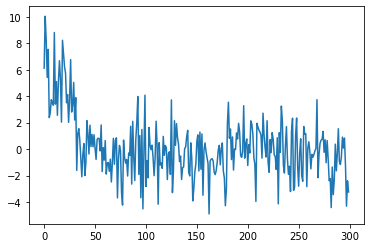

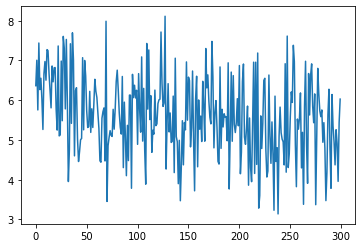

In [17]:
h1 = history.history
plt.figure()
plt.plot(history.history['g_loss'])
plt.show()

plt.figure()
plt.plot(history.history['c_loss'])
plt.show()
np.savez_compressed(file_name + '_v2.npz', g_loss=history.history['g_loss'], c_loss=history.history['c_loss'])

## Dev: Analysis made for loss function

In [73]:
difs1 = [fft1[1:] - fft1[:-1] for fft1 in electrical_data[:, :, 2]]
difs10 = [fft10[1:] - fft10[:-1] for fft10 in electrical_data[:, :, 3]]
means1 = [np.mean(dif1) for dif1 in difs1]
means10 = [np.mean(dif10) for dif10 in difs10]
print(np.mean(means1), np.mean(means10))
stds1 = [np.std(dif1) for dif1 in difs1]
stds10 = [np.std(dif10) for dif10 in difs10]
print(np.mean(stds1), np.mean(stds10))

0.0 -8.287503042759682e-09
0.0 0.0003617983160523011


1.273857143685679e-06
1.2079302100380263e-06
3.5560443478743764e-13
1.2483933533258273e-05


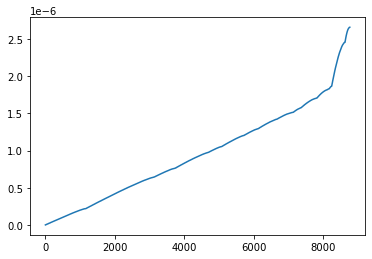

In [18]:
difs10_ord1 = [fft10[1:] - fft10[:-1] for fft10 in electrical_data[:, :, 3]]
difs10_ord2 = [np.abs(dif10_ord1[1:] - dif10_ord1[:-1]) for dif10_ord1 in difs10_ord1]
print(np.mean(difs10_ord2))
print(np.std(difs10_ord2))
print(np.min(difs10_ord2))
print(np.max(difs10_ord2))
sorted_difs = np.sort(difs10_ord2[35])
plt.plot(sorted_difs)

## Sample Data

In [1]:
cwgan_gp_sn.generator.load_weights(ckpt_dir + '/generator_weights_500.ckpt')
cwgan_gp_sn.critic.load_weights(ckpt_dir + '/critic_weights_500.ckpt')

NameError: name 'wgangp' is not defined

In [ ]:
path = 'samples_from_model'
nr_samples = 5000
nr_trials = 1000
batch_size = 50
final_samples = [None] * nr_samples
final_scores = [-9999] * nr_samples
sampled_labels = [[randint(0, 3), randint(3, 12), randint(12, 17), randint(17, 20), randint(20, 28)] for _ in range(nr_samples)]
sampled_labels = np.array(sampled_labels)

for k in range(0, 5000, batch_size):
    batch_labels = sampled_labels[k:k + batch_size]
    for i in range(nr_trials):
        noise = np.random.normal(0, 1, (batch_size, cwgan_gp_sn.noise_length))
        gen_samples = cwgan_gp_sn.generator.predict([noise, batch_labels])
        critic_scores = cwgan_gp_sn.critic.predict([gen_samples, batch_labels])
        for j, score in enumerate(critic_scores):
            if score > final_scores[k + j]:
                final_scores[k + j] = score
                final_samples[k + j] = gen_samples[j, :, 0]
    print('Finished for k =', k)

## Remove Noise

In [ ]:
final_samples = np.array(final_samples)
final_scores = np.array(final_scores)

for electrical_value in final_samples:
    new_electrical_value = irfft(rfft(electrical_value)[:1000], n=len(electrical_value))
    electrical_value[4800:5520] = new_electrical_value[4800:5520]

## Save the Data

In [ ]:
np.savez_compressed('../../data/processed/generated_data.npz', electrical_data=final_samples, labels=sampled_labels)